In [1]:
import numpy as np
import GPy
import GPyOpt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [9]:
# Load diabetes dataset
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_scaler = MinMaxScaler()
y_train = label_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = label_scaler.transform(y_test.reshape(-1, 1)).ravel()

# Define the regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

model.score(X_test_scaled, y_test)

0.45260276297191926

In [32]:
# Define the EP potential function
def ep_potential(y, y_query, w=0.2):
    term = (y_query - y) / w
    z = np.maximum(term, 0)
    aep_p = z**2 * np.exp(-(z**2))
    # z = - np.minimum(term, 0)
    # aep_m = z ** 2 * np.exp(-(z**2))
    return aep_p
    # return (y - y_query)**2 * np.exp(-((y - y_query)**2) / w)


# Objective function for Bayesian Optimization
def objective_function(X_new, index):
    X_new = X_new.reshape(1, -1)
    y_query = model.predict(
        X_test_scaled[index].reshape(1, -1)
    )  # Current prediction we want to change
    # print("Y_query: ", y_query)
    y_pred = model.predict(X_new)
    # print("Y_PRED: ", y_pred)
    # print(y_pred)
    potential = ep_potential(y_query, y_pred)
    # print(f"Potential: {potential}")
    return potential

In [42]:
# Generate counterfactuals for each test instance
counterfactuals = []

for i in tqdm(range(len(X_test_scaled[:3]))):
    domain = [
        {"name": f"var_{j}", "type": "continuous", "domain": (0, 1)}
        for j in range(X_test_scaled.shape[1])
    ]
    optimizer = GPyOpt.methods.BayesianOptimization(
        f=lambda X_new: objective_function(X_new, i),
        domain=domain,
        model_type="GP",
        acquisition_type="EI",
        normalize_Y=False,
        evaluator_type="thompson_sampling",
        maximize=True,
    )
    optimizer.run_optimization(eps=1e-3, max_iter=10)
    counterfactuals.append(optimizer.x_opt.reshape(1, -1))

# # Print some example counterfactual inputs
# print("Original vs Counterfactual for the first 5 test instances:")
# for i in range(2):
#     print(f"Original: {X_test[i]}, Counterfactual: {counterfactuals[i]}")

100%|██████████| 3/3 [00:09<00:00,  3.33s/it]


In [40]:
model.predict(X_test_scaled[:3])

array([0.35684598, 0.48136202, 0.3396846 ])

In [43]:
model.predict(np.array(counterfactuals).squeeze())

array([0.55560556, 0.68736308, 0.53428402])

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   2.195901e+01   3.379725e+01 
    00s00  0008   1.238326e+01   2.674623e+00 
    00s01  0017   8.888113e+00   6.874709e-04 
    00s02  0026   8.796488e+00   1.540587e-06 
    00s02  0029   8.796483e+00   1.808470e-13 
    00s02  0030   8.796483e+00   1.808470e-13 
Runtime:     00s02
Optimization status: Converged

Optimized model parameters:

Name : GP regression
Objective : 8.796482715265215
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   84.46370282787578  |      +ve      |        
  rbf.lengthscale          |    5.86085471266504  |      +ve      |        
  Gaussian_noise.variance  |  0.0763249246275191  |      +ve      |        


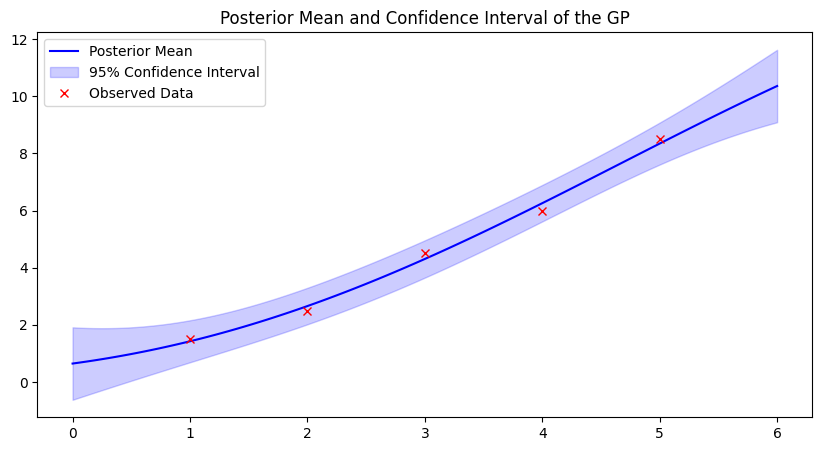

In [3]:
import numpy as np

# Print or plot the results
import matplotlib.pyplot as plt

# Sample data: D_n = {(x_i, f(x_i))} for i in [n]
X = np.array([[1], [2], [3], [4], [5]])  # Input space
y = np.array([[1.5], [2.5], [4.5], [6.0], [8.5]])  # Corresponding outputs

# Define the kernel (covariance function)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)

# Initialize the Gaussian Process model with the prior mean (zero) and the defined kernel
model = GPy.models.GPRegression(X, y, kernel)

# Optimize the model (finds the best hyperparameters and fits to the given data)
model.optimize(messages=True)

# Display the optimized model parameters
print("Optimized model parameters:")
print(model)

# Predict at new data points to see the mean and variance of the posterior
X_new = np.linspace(0, 6, 100).reshape(-1, 1)
mean, variance = model.predict(X_new)


plt.figure(figsize=(10, 5))
plt.plot(X_new, mean, "b", label="Posterior Mean")
plt.fill_between(
    X_new.flatten(),
    (mean - 1.96 * np.sqrt(variance)).flatten(),
    (mean + 1.96 * np.sqrt(variance)).flatten(),
    color="blue",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.plot(X, y, "rx", label="Observed Data")
plt.legend()
plt.title("Posterior Mean and Confidence Interval of the GP")
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0005   1.082735e+06   5.085257e+10 
    00s14  0012   1.499087e+05   1.866064e+07 
    00s19  0016   4.955542e+04   2.072552e+05 
    00s42  0050   2.302766e+03   7.689353e-12 
Runtime:     00s42
Optimization status: Converged

Optimized model parameters:

Name : GP regression
Objective : 2302.7663827295237
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  linear.variances         |  105916.81698973184  |      +ve      |        
  Gaussian_noise.variance  |  26266.347191875215  |      +ve      |        
Mean Squared Error on Test Data: 27268.16


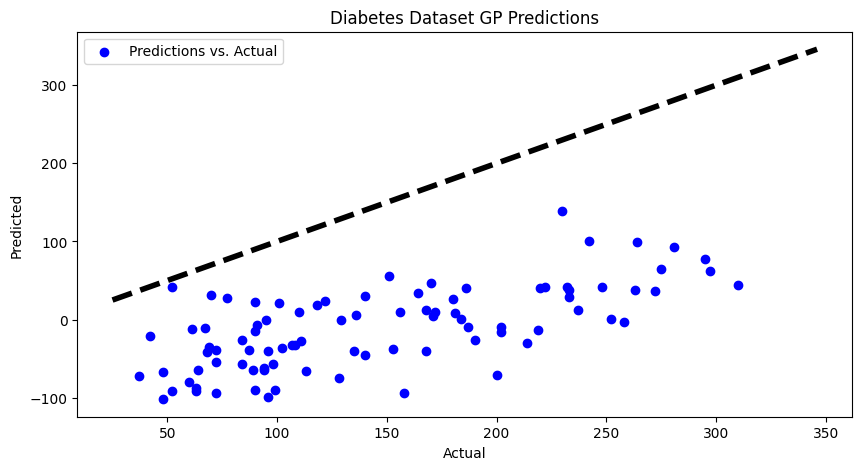

In [5]:
import GPy
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Optional: Plot predictions vs actual
import matplotlib.pyplot as plt

# Load the diabetes dataset
data = load_diabetes()
X, y = data.data, data.target
y = y.reshape(-1, 1)  # Reshape y to make it suitable for GPy

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define a linear kernel
kernel = GPy.kern.Linear(
    input_dim=X_train.shape[1]
)  # Input dimension matches the number of features

# Initialize the Gaussian Process model
model = GPy.models.GPRegression(X_train, y_train, kernel)

# Optimize the model
model.optimize(messages=True)

# Display the optimized model parameters
print("Optimized model parameters:")
print(model)

# Predict on the test data
y_pred, y_pred_var = model.predict(X_test)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse:.2f}")

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color="blue", label="Predictions vs. Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Diabetes Dataset GP Predictions")
plt.legend()
plt.show()